In [116]:
import requests
import urllib3
from bs4 import BeautifulSoup
import pandas as pd
import re
import pandas_datareader.data as web
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [94]:
df = pd.read_csv('stock_headlines_cleaned.csv')
prices = pd.read_csv('stock_prices.csv')
filings = pd.read_csv('filing_dates.csv')

In [95]:
df['date'] = pd.to_datetime(df.date)
prices['date'] = pd.to_datetime(prices.date)
filings['filing_dates'] = pd.to_datetime(filings.filing_dates)

In [96]:
df = df.sort_values('date', ascending = True)
prices = prices.sort_values('date', ascending = True)
filings = filings.sort_values('filing_dates', ascending = True)

In [97]:
#check if earnings was reported within 4 weeks of headline date, if so remove
filings['filing_dates'] = pd.to_datetime(filings.filing_dates)
filings = filings.sort_values('filing_dates')

df = pd.merge_asof(df, filings, by = 'ticker', left_on = 'date', right_on = 'filing_dates', direction = 'forward',
                    allow_exact_matches = False)

#fill missing filing dates with arbitrary old date
df['filing_dates'] = df.filing_dates.fillna(pd.to_datetime('2001-01-01'))
df['days_from_filing'] = np.busday_count(df.date.tolist(), df.filing_dates.tolist())

#remove rows where filing date is within 19 business days of headline (4 weeks - 1 day, earnings could be released after hours on last day)
df = df[df.days_from_filing.abs() > 19]

In [99]:
#remove stocks with no price movement
df = df[df.price_move != 0]

In [100]:
len(df)

19218

In [101]:
up = df[df.price_move > 0]
down = df[df.price_move < 0]

In [102]:
len(up)

9964

In [103]:
len(down)

9254

In [308]:
#function for getting stocks with certain movement criteria and their price changes 1 month after relative to starting price
def get_price_deviations(df, prices): #prices should be grouped by ticker and then sorted by date
    result = pd.DataFrame({'days':[i for i in range(21)]})
    d = df.to_dict(orient = 'records') #convert to list of dictionaries, iterates faster
    for i in range(len(d)):
        t = d[i]['ticker']
        start_dt = d[i]['date'] - BDay(1)

        p = prices[prices.ticker == t].reset_index(drop = True)
        while len(p[(p.date == start_dt)]) == 0: #if the above calculated start_dt is on a holiday, get last trading day
            start_dt = start_dt - BDay(1)

        #get next 20 trading days prices from start date
        p = p[(p.date >= start_dt) & (p.index <= p[p.date == start_dt].index.values[0] + 20)]

        p = p.sort_values('date')
        

        p['days'] = [i for i in range(0, len(p))]

        start_price = p.close.values[0]

        col_name = t + '_' + str(d[i]['date'])

        p[col_name] = (p.close / start_price) - 1
        p = p[[col_name]].reset_index(drop = True)

        result = pd.concat([result, p], axis = 1)
    return(result)

In [105]:
%time u_5 = get_price_deviations(up[(up.price_move > 0) & (up.price_move <= 0.05)], prices[prices.ticker.isin(up[(up.price_move > 0) & (up.price_move <= 0.05)].ticker)])
%time u_5_10 = get_price_deviations(up[(up.price_move > 0.05) & (up.price_move <= 0.1)], prices[prices.ticker.isin(up[(up.price_move > 0.05) & (up.price_move <= 0.1)].ticker)])
%time u_10_15 = get_price_deviations(up[(up.price_move > 0.1) & (up.price_move <= 0.15)], prices[prices.ticker.isin(up[(up.price_move > 0.1) & (up.price_move <= 0.15)].ticker)])
%time u_15_20 = get_price_deviations(up[(up.price_move > 0.15) & (up.price_move <= 0.2)], prices[prices.ticker.isin(up[(up.price_move > 0.15) & (up.price_move <= 0.2)].ticker)])
%time u_20_30 = get_price_deviations(up[(up.price_move > 0.2) & (up.price_move <= 0.3)], prices[prices.ticker.isin(up[(up.price_move > 0.2) & (up.price_move <= 0.3)].ticker)])
%time u_30 = get_price_deviations(up[(up.price_move > 0.3)], prices[prices.ticker.isin(up[(up.price_move > 0.3)].ticker)])

CPU times: user 44.9 s, sys: 365 ms, total: 45.3 s
Wall time: 46.4 s
CPU times: user 4min 4s, sys: 497 ms, total: 4min 5s
Wall time: 4min 5s
CPU times: user 5min 11s, sys: 664 ms, total: 5min 11s
Wall time: 5min 13s
CPU times: user 1min 59s, sys: 252 ms, total: 2min
Wall time: 2min
CPU times: user 1min 9s, sys: 149 ms, total: 1min 9s
Wall time: 1min 9s
CPU times: user 47.1 s, sys: 68.1 ms, total: 47.2 s
Wall time: 47.2 s


In [106]:
#get average movements
for temp in [u_5, u_5_10, u_10_15, u_15_20, u_20_30, u_30]:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

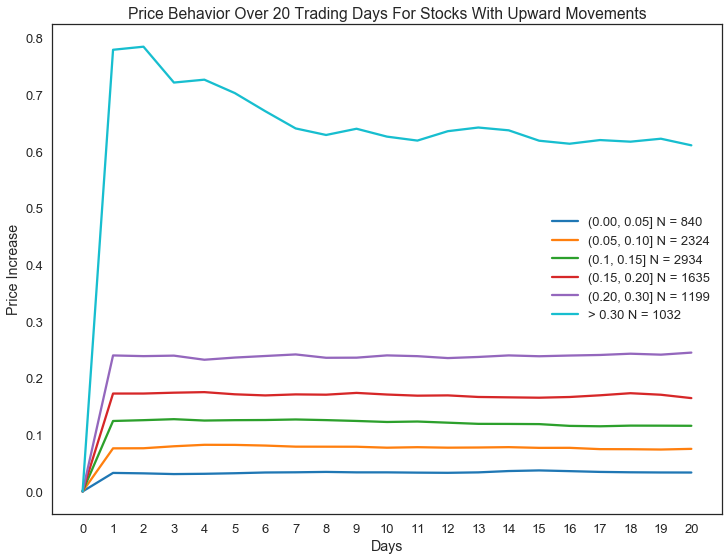

In [277]:
#plot different movements
fig = plt.subplot()

u_5[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, figsize = [12, 9], color = 'tab:blue')
u_5_10[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:orange')
u_10_15[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:green')
u_15_20[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:red')
u_20_30[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:purple')
u_30[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:cyan')

plt.xticks(range(21))
plt.legend(['(0.00, 0.05] N = %d'%(u_5.shape[1]-2), '(0.05, 0.10] N = %d'%(u_5_10.shape[1]-2), 
            '(0.1, 0.15] N = %d'%(u_10_15.shape[1]-2), '(0.15, 0.20] N = %d'%(u_15_20.shape[1]-2), 
            '(0.20, 0.30] N = %d'%(u_20_30.shape[1]-2),'> 0.30 N = %d'%(u_30.shape[1]-2)])

plt.ylabel('Price Increase');
plt.xlabel('Days');

plt.title('Price Behavior Over 20 Trading Days For Stocks With Upward Movements');

In [108]:
len(down)

9254

In [109]:
%time d_5 = get_price_deviations(down[(down.price_move < 0) & (down.price_move >= -0.05)], prices[prices.ticker.isin(down[(down.price_move < 0) & (down.price_move >= -0.05)].ticker)])
%time d_5_10 = get_price_deviations(down[(down.price_move < -0.05) & (down.price_move >= -0.1)], prices[prices.ticker.isin(down[(down.price_move < -0.05) & (down.price_move >= -0.1)].ticker)])
%time d_10_15 = get_price_deviations(down[(down.price_move < -0.1) & (down.price_move >= -0.15)], prices[prices.ticker.isin(down[(down.price_move < -0.1) & (down.price_move >= -0.15)].ticker)])
%time d_15_20 = get_price_deviations(down[(down.price_move < -0.15) & (down.price_move >= -0.2)], prices[prices.ticker.isin(down[(down.price_move < -0.15) & (down.price_move >= -0.2)].ticker)])
%time d_20_30 = get_price_deviations(down[(down.price_move < -0.2) & (down.price_move >= -0.3)], prices[prices.ticker.isin(down[(down.price_move < -0.2) & (down.price_move >= -0.3)].ticker)])
%time d_30 = get_price_deviations(down[(down.price_move < -0.3)], prices[prices.ticker.isin(down[(down.price_move < -0.3)].ticker)])

CPU times: user 46.1 s, sys: 357 ms, total: 46.4 s
Wall time: 47.3 s
CPU times: user 4min 25s, sys: 833 ms, total: 4min 26s
Wall time: 4min 28s
CPU times: user 5min 47s, sys: 2.26 s, total: 5min 49s
Wall time: 5min 59s
CPU times: user 1min 47s, sys: 930 ms, total: 1min 48s
Wall time: 1min 53s
CPU times: user 1min, sys: 522 ms, total: 1min 1s
Wall time: 1min 5s
CPU times: user 24.1 s, sys: 228 ms, total: 24.4 s
Wall time: 27.2 s


In [110]:
#get average movements
for temp in [d_5, d_5_10, d_10_15, d_15_20, d_20_30, d_30]:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

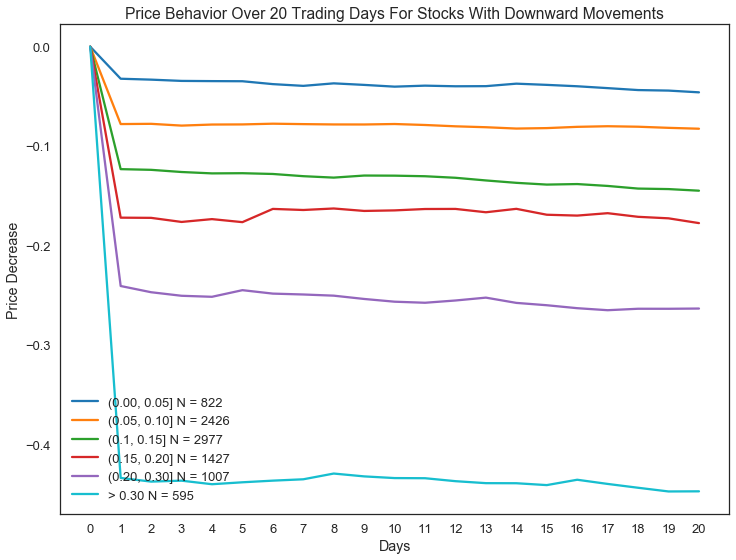

In [278]:
#plot different movements
fig = plt.subplot()

d_5[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, figsize = [12, 9], color = 'tab:blue')
d_5_10[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:orange')
d_10_15[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:green')
d_15_20[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:red')
d_20_30[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:purple')
d_30[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:cyan')

plt.xticks(range(21))
plt.legend(['(0.00, 0.05] N = %d'%(d_5.shape[1]-2), '(0.05, 0.10] N = %d'%(d_5_10.shape[1]-2), 
            '(0.1, 0.15] N = %d'%(d_10_15.shape[1]-2), '(0.15, 0.20] N = %d'%(d_15_20.shape[1]-2), 
            '(0.20, 0.30] N = %d'%(d_20_30.shape[1]-2), '> 0.30 N = %d'%(d_30.shape[1]-2)])

plt.ylabel('Price Decrease');
plt.xlabel('Days');
plt.title('Price Behavior Over 20 Trading Days For Stocks With Downward Movements');

In [ ]:
#compare stocks with golden crosses

In [119]:
up_30 = up[up.price_move > 0.3]
up_20_30 = up[(up.price_move > 0.2) & (up.price_move <= 0.3)]
up_15_20 = up[(up.price_move > 0.15) & (up.price_move <= 0.2)]
up_10_15 = up[(up.price_move > 0.1) & (up.price_move <= 0.15)]
up_5_10 = up[(up.price_move > 0.05) & (up.price_move <= 0.1)]
up_5 = up[(up.price_move <= 0.05)]

In [120]:
down_30 = down[down.price_move < -0.3]
down_20_30 = down[(down.price_move < -0.2) & (down.price_move >= -0.3)]
down_15_20 = down[(down.price_move < -0.15) & (down.price_move >= -0.2)]
down_10_15 = down[(down.price_move < -0.1) & (down.price_move >= -0.15)]
down_5_10 = down[(down.price_move < -0.05) & (down.price_move >= -0.1)]
down_5 = down[(down.price_move >= -0.05)]

In [121]:
#successful 50-200 golden cross and upward stock movement
%time gcs_30 = get_price_deviations(up_30[(up_30.price_50_dma > up_30.price_200_dma)], prices[prices.ticker.isin(up_30[(up_30.price_50_dma > up_30.price_200_dma)].ticker)])
%time gcs_20_30 = get_price_deviations(up_20_30[(up_20_30.price_50_dma > up_20_30.price_200_dma)], prices[prices.ticker.isin(up_20_30[(up_20_30.price_50_dma > up_20_30.price_200_dma)].ticker)])
%time gcs_15_20 = get_price_deviations(up_15_20[(up_15_20.price_50_dma > up_15_20.price_200_dma)], prices[prices.ticker.isin(up_15_20[(up_15_20.price_50_dma > up_15_20.price_200_dma)].ticker)])
%time gcs_10_15 = get_price_deviations(up_10_15[(up_10_15.price_50_dma > up_10_15.price_200_dma)], prices[prices.ticker.isin(up_10_15[(up_10_15.price_50_dma > up_10_15.price_200_dma)].ticker)])
%time gcs_5_10 = get_price_deviations(up_5_10[(up_5_10.price_50_dma > up_5_10.price_200_dma)], prices[prices.ticker.isin(up_5_10[(up_5_10.price_50_dma > up_5_10.price_200_dma)].ticker)])
%time gcs_5 = get_price_deviations(up_5[(up_5.price_50_dma > up_5.price_200_dma)], prices[prices.ticker.isin(up_5[(up_5.price_50_dma > up_5.price_200_dma)].ticker)])

#unsuccessful 50-200 golden cross and upward stock movement
%time gcf_30 = get_price_deviations(up_30[(up_30.price_50_dma <= up_30.price_200_dma)], prices[prices.ticker.isin(up_30[(up_30.price_50_dma <= up_30.price_200_dma)].ticker)])
%time gcf_20_30 = get_price_deviations(up_20_30[(up_20_30.price_50_dma <= up_20_30.price_200_dma)], prices[prices.ticker.isin(up_20_30[(up_20_30.price_50_dma <= up_20_30.price_200_dma)].ticker)])
%time gcf_15_20 = get_price_deviations(up_15_20[(up_15_20.price_50_dma <= up_15_20.price_200_dma)], prices[prices.ticker.isin(up_15_20[(up_15_20.price_50_dma <= up_15_20.price_200_dma)].ticker)])
%time gcf_10_15 = get_price_deviations(up_10_15[(up_10_15.price_50_dma <= up_10_15.price_200_dma)], prices[prices.ticker.isin(up_10_15[(up_10_15.price_50_dma <= up_10_15.price_200_dma)].ticker)])
%time gcf_5_10 = get_price_deviations(up_5_10[(up_5_10.price_50_dma <= up_5_10.price_200_dma)], prices[prices.ticker.isin(up_5_10[(up_5_10.price_50_dma <= up_5_10.price_200_dma)].ticker)])
%time gcf_5 = get_price_deviations(up_5[(up_5.price_50_dma <= up_5.price_200_dma)], prices[prices.ticker.isin(up_5[(up_5.price_50_dma <= up_5.price_200_dma)].ticker)])

CPU times: user 6.95 s, sys: 280 ms, total: 7.23 s
Wall time: 7.34 s
CPU times: user 14.6 s, sys: 140 ms, total: 14.7 s
Wall time: 15.5 s
CPU times: user 27.7 s, sys: 125 ms, total: 27.9 s
Wall time: 28.2 s
CPU times: user 1min 6s, sys: 182 ms, total: 1min 6s
Wall time: 1min 6s
CPU times: user 1min 3s, sys: 135 ms, total: 1min 3s
Wall time: 1min 4s
CPU times: user 16.7 s, sys: 42 ms, total: 16.7 s
Wall time: 16.8 s
CPU times: user 23.1 s, sys: 50.7 ms, total: 23.1 s
Wall time: 23.2 s
CPU times: user 29 s, sys: 206 ms, total: 29.3 s
Wall time: 30.1 s
CPU times: user 39.2 s, sys: 142 ms, total: 39.4 s
Wall time: 39.7 s
CPU times: user 1min 50s, sys: 785 ms, total: 1min 51s
Wall time: 1min 56s
CPU times: user 1min 14s, sys: 433 ms, total: 1min 15s
Wall time: 1min 16s
CPU times: user 9.07 s, sys: 37.5 ms, total: 9.11 s
Wall time: 9.16 s


In [122]:
#successful 50-200 death cross and downward stock movement
%time dcs_30 = get_price_deviations(down_30[(down_30.price_50_dma < down_30.price_200_dma)], prices[prices.ticker.isin(down_30[(down_30.price_50_dma < down_30.price_200_dma)].ticker)])
%time dcs_20_30 = get_price_deviations(down_20_30[(down_20_30.price_50_dma < down_20_30.price_200_dma)], prices[prices.ticker.isin(down_20_30[(down_20_30.price_50_dma < down_20_30.price_200_dma)].ticker)])
%time dcs_15_20 = get_price_deviations(down_15_20[(down_15_20.price_50_dma < down_15_20.price_200_dma)], prices[prices.ticker.isin(down_15_20[(down_15_20.price_50_dma < down_15_20.price_200_dma)].ticker)])
%time dcs_10_15 = get_price_deviations(down_10_15[(down_10_15.price_50_dma < down_10_15.price_200_dma)], prices[prices.ticker.isin(down_10_15[(down_10_15.price_50_dma < down_10_15.price_200_dma)].ticker)])
%time dcs_5_10 = get_price_deviations(down_5_10[(down_5_10.price_50_dma < down_5_10.price_200_dma)], prices[prices.ticker.isin(down_5_10[(down_5_10.price_50_dma < down_5_10.price_200_dma)].ticker)])
%time dcs_5 = get_price_deviations(down_5[(down_5.price_50_dma < down_5.price_200_dma)], prices[prices.ticker.isin(down_5[(down_5.price_50_dma < down_5.price_200_dma)].ticker)])

#unsuccessful 50-200 death cross and downward stock movement
%time dcf_30 = get_price_deviations(down_30[(down_30.price_50_dma >= down_30.price_200_dma)], prices[prices.ticker.isin(down_30[(down_30.price_50_dma >= down_30.price_200_dma)].ticker)])
%time dcf_20_30 = get_price_deviations(down_20_30[(down_20_30.price_50_dma >= down_20_30.price_200_dma)], prices[prices.ticker.isin(down_20_30[(down_20_30.price_50_dma >= down_20_30.price_200_dma)].ticker)])
%time dcf_15_20 = get_price_deviations(down_15_20[(down_15_20.price_50_dma >= down_15_20.price_200_dma)], prices[prices.ticker.isin(down_15_20[(down_15_20.price_50_dma >= down_15_20.price_200_dma)].ticker)])
%time dcf_10_15 = get_price_deviations(down_10_15[(down_10_15.price_50_dma >= down_10_15.price_200_dma)], prices[prices.ticker.isin(down_10_15[(down_10_15.price_50_dma >= down_10_15.price_200_dma)].ticker)])
%time dcf_5_10 = get_price_deviations(down_5_10[(down_5_10.price_50_dma >= down_5_10.price_200_dma)], prices[prices.ticker.isin(down_5_10[(down_5_10.price_50_dma >= down_5_10.price_200_dma)].ticker)])
%time dcf_5 = get_price_deviations(down_5[(down_5.price_50_dma >= down_5.price_200_dma)], prices[prices.ticker.isin(down_5[(down_5.price_50_dma >= down_5.price_200_dma)].ticker)])

CPU times: user 12.5 s, sys: 175 ms, total: 12.7 s
Wall time: 13.7 s
CPU times: user 20.5 s, sys: 83 ms, total: 20.6 s
Wall time: 20.9 s
CPU times: user 33.6 s, sys: 75.1 ms, total: 33.7 s
Wall time: 33.8 s
CPU times: user 1min 48s, sys: 621 ms, total: 1min 49s
Wall time: 1min 51s
CPU times: user 1min 18s, sys: 583 ms, total: 1min 19s
Wall time: 1min 21s
CPU times: user 10.6 s, sys: 68.4 ms, total: 10.7 s
Wall time: 10.8 s
CPU times: user 4.28 s, sys: 38.9 ms, total: 4.32 s
Wall time: 4.46 s
CPU times: user 10.6 s, sys: 55 ms, total: 10.7 s
Wall time: 10.8 s
CPU times: user 21.2 s, sys: 154 ms, total: 21.3 s
Wall time: 21.9 s
CPU times: user 1min 14s, sys: 448 ms, total: 1min 14s
Wall time: 1min 16s
CPU times: user 1min 14s, sys: 361 ms, total: 1min 14s
Wall time: 1min 15s
CPU times: user 14.9 s, sys: 74.7 ms, total: 15 s
Wall time: 15.1 s


In [123]:
cross_ls = [gcs_30, gcs_20_30, gcs_15_20, gcs_10_15, gcs_5_10, gcs_5, 
            gcf_30, gcf_20_30, gcf_15_20, gcf_10_15, gcf_5_10, gcf_5,
            dcs_30, dcs_20_30, dcs_15_20, dcs_10_15, dcs_5_10, dcs_5, 
            dcf_30, dcf_20_30, dcf_15_20, dcf_10_15, dcf_5_10, dcf_5]

#get average movements
for temp in cross_ls:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

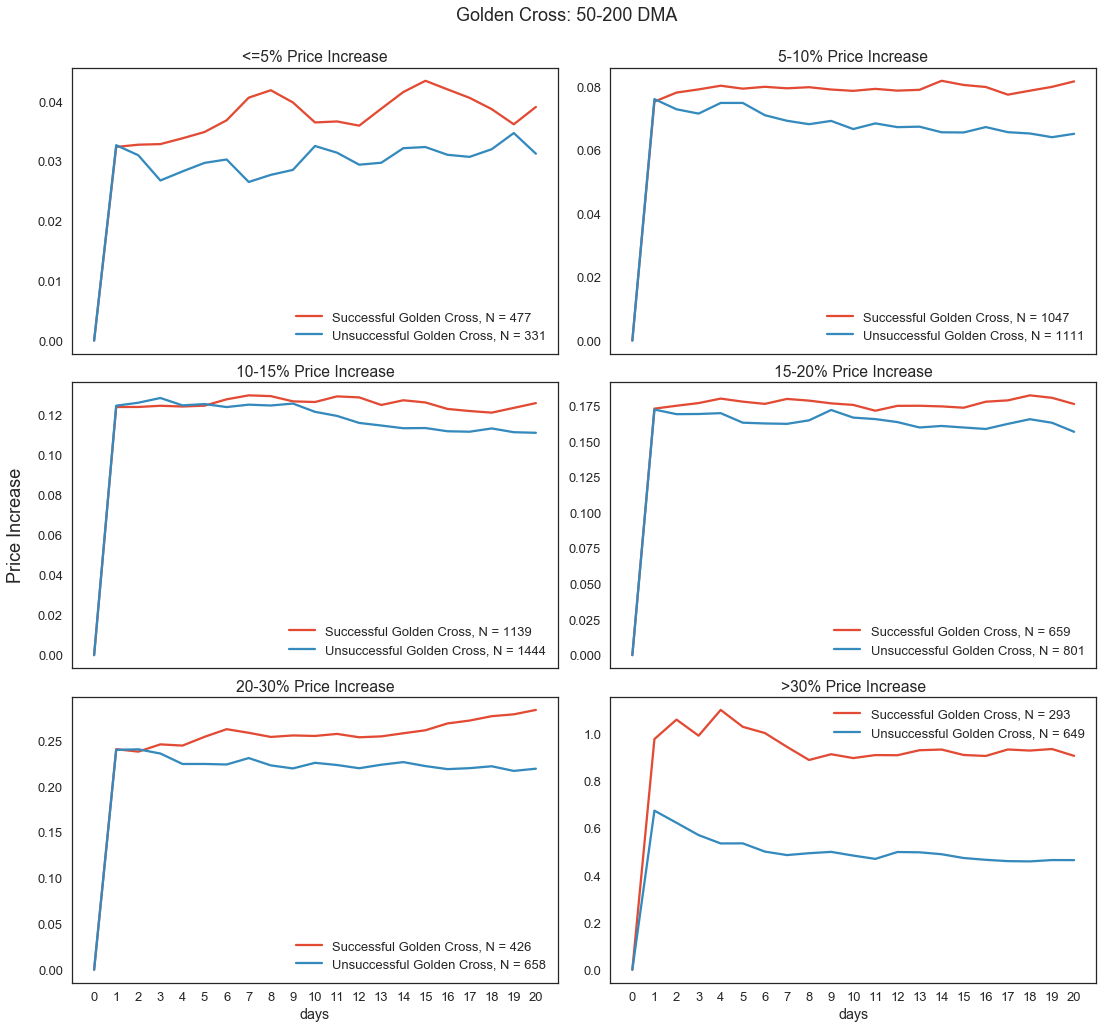

In [298]:
fig, axes = plt.subplots(3, 2, sharex = True)

#golden cross, price <= 5% increase
gcs_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [15, 15])
gcf_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].legend(['Successful Golden Cross, N = %d'%(gcs_5.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_5.shape[1]-2)])
axes[0,0].set_xticks(range(21))
axes[0,0].set_title('<=5% Price Increase')

#golden cross, price 5-10% increase
gcs_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
gcf_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].legend(['Successful Golden Cross, N = %d'%(gcs_5_10.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_5_10.shape[1]-2)])
axes[0,1].set_xticks(range(21));
axes[0,1].set_title('5-10% Price Increase')


#golden cross, price 10-15% increase
gcs_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
gcf_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].legend(['Successful Golden Cross, N = %d'%(gcs_10_15.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_10_15.shape[1]-2)])
axes[1,0].set_xticks(range(21));
axes[1,0].set_title('10-15% Price Increase')


#golden cross, price 15-20% increase
gcs_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
gcf_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].legend(['Successful Golden Cross, N = %d'%(gcs_15_20.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_15_20.shape[1]-2)])
axes[1,1].set_xticks(range(21));
axes[1,1].set_title('15-20% Price Increase')


#golden cross, price 20-30% increase
gcs_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
gcf_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].legend(['Successful Golden Cross, N = %d'%(gcs_20_30.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_20_30.shape[1]-2)])
axes[2,0].set_xticks(range(21));
axes[2,0].set_title('20-30% Price Increase')


#golden cross, price > 30% increase
gcs_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
gcf_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].legend(['Successful Golden Cross, N = %d'%(gcs_30.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_30.shape[1]-2)])
axes[2,1].set_xticks(range(21));
axes[2,1].set_title('>30% Price Increase');

fig.suptitle('Golden Cross: 50-200 DMA', size = 18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.text(-0.01, 0.5, 'Price Increase', ha='center', va='center', rotation='vertical', size = 18);


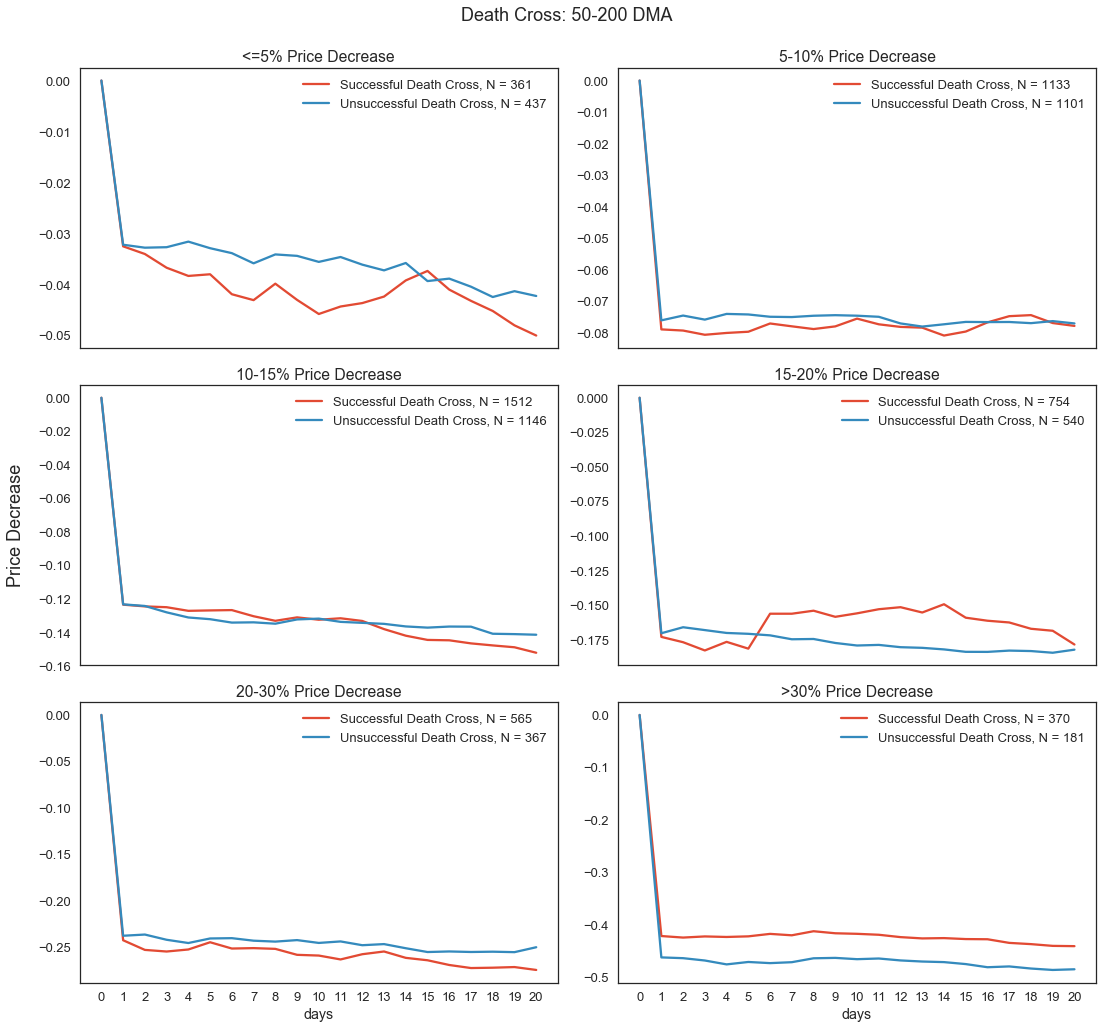

In [299]:
fig, axes = plt.subplots(3, 2, sharex = True)

#Death cross, price <= 5% Decrease
dcs_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [15, 15])
dcf_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].legend(['Successful Death Cross, N = %d'%(dcs_5.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_5.shape[1]-2)])
axes[0,0].set_xticks(range(21))
axes[0,0].set_title('<=5% Price Decrease')

#Death cross, price 5-10% Decrease
dcs_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
dcf_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].legend(['Successful Death Cross, N = %d'%(dcs_5_10.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_5_10.shape[1]-2)])
axes[0,1].set_xticks(range(21));
axes[0,1].set_title('5-10% Price Decrease')


#Death cross, price 10-15% Decrease
dcs_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
dcf_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].legend(['Successful Death Cross, N = %d'%(dcs_10_15.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_10_15.shape[1]-2)])
axes[1,0].set_xticks(range(21));
axes[1,0].set_title('10-15% Price Decrease')


#Death cross, price 15-20% Decrease
dcs_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
dcf_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].legend(['Successful Death Cross, N = %d'%(dcs_15_20.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_15_20.shape[1]-2)])
axes[1,1].set_xticks(range(21));
axes[1,1].set_title('15-20% Price Decrease')


#Death cross, price 20-30% Decrease
dcs_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
dcf_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].legend(['Successful Death Cross, N = %d'%(dcs_20_30.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_20_30.shape[1]-2)])
axes[2,0].set_xticks(range(21));
axes[2,0].set_title('20-30% Price Decrease')


#Death cross, price > 30% Decrease
dcs_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
dcf_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].legend(['Successful Death Cross, N = %d'%(dcs_30.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_30.shape[1]-2)])
axes[2,1].set_xticks(range(21));
axes[2,1].set_title('>30% Price Decrease');

fig.suptitle('Death Cross: 50-200 DMA', size = 18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(-0.01, 0.5, 'Price Decrease', ha='center', va='center', rotation='vertical', size = 18);


In [126]:
#successful 5-20 golden cross and upward stock movement
%time gcs2_30 = get_price_deviations(up_30[(up_30.price_5_dma > up_30.price_20_dma)], prices[prices.ticker.isin(up_30[(up_30.price_5_dma > up_30.price_20_dma)].ticker)])
%time gcs2_20_30 = get_price_deviations(up_20_30[(up_20_30.price_5_dma > up_20_30.price_20_dma)], prices[prices.ticker.isin(up_20_30[(up_20_30.price_5_dma > up_20_30.price_20_dma)].ticker)])
%time gcs2_15_20 = get_price_deviations(up_15_20[(up_15_20.price_5_dma > up_15_20.price_20_dma)], prices[prices.ticker.isin(up_15_20[(up_15_20.price_5_dma > up_15_20.price_20_dma)].ticker)])
%time gcs2_10_15 = get_price_deviations(up_10_15[(up_10_15.price_5_dma > up_10_15.price_20_dma)], prices[prices.ticker.isin(up_10_15[(up_10_15.price_5_dma > up_10_15.price_20_dma)].ticker)])
%time gcs2_5_10 = get_price_deviations(up_5_10[(up_5_10.price_5_dma > up_5_10.price_20_dma)], prices[prices.ticker.isin(up_5_10[(up_5_10.price_5_dma > up_5_10.price_20_dma)].ticker)])
%time gcs2_5 = get_price_deviations(up_5[(up_5.price_5_dma > up_5.price_20_dma)], prices[prices.ticker.isin(up_5[(up_5.price_5_dma > up_5.price_20_dma)].ticker)])

#unsuccessful 5-20 golden cross and upward stock movement
%time gcf2_30 = get_price_deviations(up_30[(up_30.price_5_dma <= up_30.price_20_dma)], prices[prices.ticker.isin(up_30[(up_30.price_5_dma <= up_30.price_20_dma)].ticker)])
%time gcf2_20_30 = get_price_deviations(up_20_30[(up_20_30.price_5_dma <= up_20_30.price_20_dma)], prices[prices.ticker.isin(up_20_30[(up_20_30.price_5_dma <= up_20_30.price_20_dma)].ticker)])
%time gcf2_15_20 = get_price_deviations(up_15_20[(up_15_20.price_5_dma <= up_15_20.price_20_dma)], prices[prices.ticker.isin(up_15_20[(up_15_20.price_5_dma <= up_15_20.price_20_dma)].ticker)])
%time gcf2_10_15 = get_price_deviations(up_10_15[(up_10_15.price_5_dma <= up_10_15.price_20_dma)], prices[prices.ticker.isin(up_10_15[(up_10_15.price_5_dma <= up_10_15.price_20_dma)].ticker)])
%time gcf2_5_10 = get_price_deviations(up_5_10[(up_5_10.price_5_dma <= up_5_10.price_20_dma)], prices[prices.ticker.isin(up_5_10[(up_5_10.price_5_dma <= up_5_10.price_20_dma)].ticker)])
%time gcf2_5 = get_price_deviations(up_5[(up_5.price_5_dma <= up_5.price_20_dma)], prices[prices.ticker.isin(up_5[(up_5.price_5_dma <= up_5.price_20_dma)].ticker)])

CPU times: user 31.4 s, sys: 178 ms, total: 31.6 s
Wall time: 31.9 s
CPU times: user 37.1 s, sys: 108 ms, total: 37.2 s
Wall time: 37.3 s
CPU times: user 56.5 s, sys: 326 ms, total: 56.8 s
Wall time: 57.3 s
CPU times: user 2min 32s, sys: 500 ms, total: 2min 33s
Wall time: 2min 34s
CPU times: user 1min 43s, sys: 251 ms, total: 1min 44s
Wall time: 1min 44s
CPU times: user 17.6 s, sys: 52.9 ms, total: 17.7 s
Wall time: 17.7 s
CPU times: user 4.95 s, sys: 22 ms, total: 4.97 s
Wall time: 4.99 s
CPU times: user 9.46 s, sys: 31 ms, total: 9.49 s
Wall time: 9.5 s
CPU times: user 21.7 s, sys: 47.3 ms, total: 21.7 s
Wall time: 21.7 s
CPU times: user 55.7 s, sys: 175 ms, total: 55.9 s
Wall time: 56.1 s
CPU times: user 59.3 s, sys: 512 ms, total: 59.8 s
Wall time: 1min 15s
CPU times: user 9.74 s, sys: 72.4 ms, total: 9.81 s
Wall time: 10.3 s


In [127]:
#successful 5-20 death cross and downward stock movement
%time dcs2_30 = get_price_deviations(down_30[(down_30.price_5_dma < down_30.price_20_dma)], prices[prices.ticker.isin(down_30[(down_30.price_5_dma < down_30.price_20_dma)].ticker)])
%time dcs2_20_30 = get_price_deviations(down_20_30[(down_20_30.price_5_dma < down_20_30.price_20_dma)], prices[prices.ticker.isin(down_20_30[(down_20_30.price_5_dma < down_20_30.price_20_dma)].ticker)])
%time dcs2_15_20 = get_price_deviations(down_15_20[(down_15_20.price_5_dma < down_15_20.price_20_dma)], prices[prices.ticker.isin(down_15_20[(down_15_20.price_5_dma < down_15_20.price_20_dma)].ticker)])
%time dcs2_10_15 = get_price_deviations(down_10_15[(down_10_15.price_5_dma < down_10_15.price_20_dma)], prices[prices.ticker.isin(down_10_15[(down_10_15.price_5_dma < down_10_15.price_20_dma)].ticker)])
%time dcs2_5_10 = get_price_deviations(down_5_10[(down_5_10.price_5_dma < down_5_10.price_20_dma)], prices[prices.ticker.isin(down_5_10[(down_5_10.price_5_dma < down_5_10.price_20_dma)].ticker)])
%time dcs2_5 = get_price_deviations(down_5[(down_5.price_5_dma < down_5.price_20_dma)], prices[prices.ticker.isin(down_5[(down_5.price_5_dma < down_5.price_20_dma)].ticker)])

#unsuccessful 5-20 death cross and downward stock movement
%time dcf2_30 = get_price_deviations(down_30[(down_30.price_5_dma >= down_30.price_20_dma)], prices[prices.ticker.isin(down_30[(down_30.price_5_dma >= down_30.price_20_dma)].ticker)])
%time dcf2_20_30 = get_price_deviations(down_20_30[(down_20_30.price_5_dma >= down_20_30.price_20_dma)], prices[prices.ticker.isin(down_20_30[(down_20_30.price_5_dma >= down_20_30.price_20_dma)].ticker)])
%time dcf2_15_20 = get_price_deviations(down_15_20[(down_15_20.price_5_dma >= down_15_20.price_20_dma)], prices[prices.ticker.isin(down_15_20[(down_15_20.price_5_dma >= down_15_20.price_20_dma)].ticker)])
%time dcf2_10_15 = get_price_deviations(down_10_15[(down_10_15.price_5_dma >= down_10_15.price_20_dma)], prices[prices.ticker.isin(down_10_15[(down_10_15.price_5_dma >= down_10_15.price_20_dma)].ticker)])
%time dcf2_5_10 = get_price_deviations(down_5_10[(down_5_10.price_5_dma >= down_5_10.price_20_dma)], prices[prices.ticker.isin(down_5_10[(down_5_10.price_5_dma >= down_5_10.price_20_dma)].ticker)])
%time dcf2_5 = get_price_deviations(down_5[(down_5.price_5_dma >= down_5.price_20_dma)], prices[prices.ticker.isin(down_5[(down_5.price_5_dma >= down_5.price_20_dma)].ticker)])

CPU times: user 16.6 s, sys: 235 ms, total: 16.8 s
Wall time: 23 s
CPU times: user 29.9 s, sys: 225 ms, total: 30.1 s
Wall time: 32.7 s
CPU times: user 48.2 s, sys: 519 ms, total: 48.7 s
Wall time: 56.2 s
CPU times: user 2min 20s, sys: 901 ms, total: 2min 21s
Wall time: 2min 24s
CPU times: user 1min 28s, sys: 378 ms, total: 1min 28s
Wall time: 1min 29s
CPU times: user 12.8 s, sys: 70.4 ms, total: 12.8 s
Wall time: 12.9 s
CPU times: user 2.92 s, sys: 16.4 ms, total: 2.94 s
Wall time: 2.94 s
CPU times: user 8.36 s, sys: 43.4 ms, total: 8.4 s
Wall time: 8.47 s
CPU times: user 20.5 s, sys: 84.7 ms, total: 20.6 s
Wall time: 20.7 s
CPU times: user 1min 14s, sys: 375 ms, total: 1min 15s
Wall time: 1min 15s
CPU times: user 1min 17s, sys: 394 ms, total: 1min 17s
Wall time: 1min 18s
CPU times: user 14.1 s, sys: 87.5 ms, total: 14.1 s
Wall time: 14.2 s


In [128]:
cross_ls = [gcs2_30, gcs2_20_30, gcs2_15_20, gcs2_10_15, gcs2_5_10, gcs2_5, 
            gcf2_30, gcf2_20_30, gcf2_15_20, gcf2_10_15, gcf2_5_10, gcf2_5,
            dcs2_30, dcs2_20_30, dcs2_15_20, dcs2_10_15, dcs2_5_10, dcs2_5, 
            dcf2_30, dcf2_20_30, dcf2_15_20, dcf2_10_15, dcf2_5_10, dcf2_5]

#get average movements
for temp in cross_ls:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

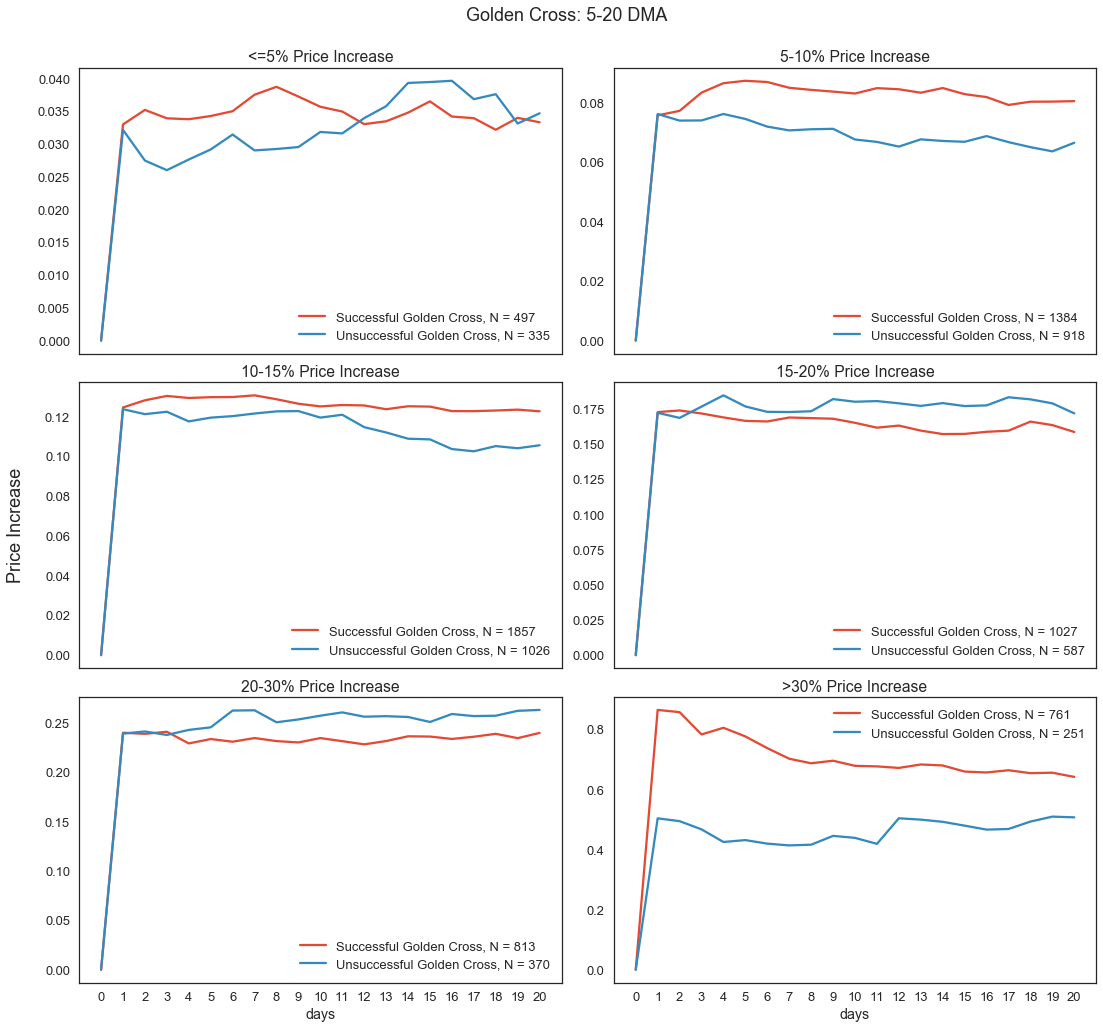

In [300]:
fig, axes = plt.subplots(3, 2, sharex = True)

#golden cross, price <= 5% increase
gcs2_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [15, 15])
gcf2_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].legend(['Successful Golden Cross, N = %d'%(gcs2_5.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_5.shape[1]-2)])
axes[0,0].set_xticks(range(21))
axes[0,0].set_title('<=5% Price Increase')

#golden cross, price 5-10% increase
gcs2_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
gcf2_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].legend(['Successful Golden Cross, N = %d'%(gcs2_5_10.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_5_10.shape[1]-2)])
axes[0,1].set_xticks(range(21));
axes[0,1].set_title('5-10% Price Increase')


#golden cross, price 10-15% increase
gcs2_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
gcf2_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].legend(['Successful Golden Cross, N = %d'%(gcs2_10_15.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_10_15.shape[1]-2)])
axes[1,0].set_xticks(range(21));
axes[1,0].set_title('10-15% Price Increase')


#golden cross, price 15-20% increase
gcs2_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
gcf2_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].legend(['Successful Golden Cross, N = %d'%(gcs2_15_20.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_15_20.shape[1]-2)])
axes[1,1].set_xticks(range(21));
axes[1,1].set_title('15-20% Price Increase')


#golden cross, price 20-30% increase
gcs2_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
gcf2_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].legend(['Successful Golden Cross, N = %d'%(gcs2_20_30.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_20_30.shape[1]-2)])
axes[2,0].set_xticks(range(21));
axes[2,0].set_title('20-30% Price Increase')


#golden cross, price > 30% increase
gcs2_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
gcf2_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].legend(['Successful Golden Cross, N = %d'%(gcs2_30.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_30.shape[1]-2)])
axes[2,1].set_xticks(range(21));
axes[2,1].set_title('>30% Price Increase');

fig.suptitle('Golden Cross: 5-20 DMA', size = 18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(-0.01, 0.5, 'Price Increase', ha='center', va='center', rotation='vertical', size = 18);


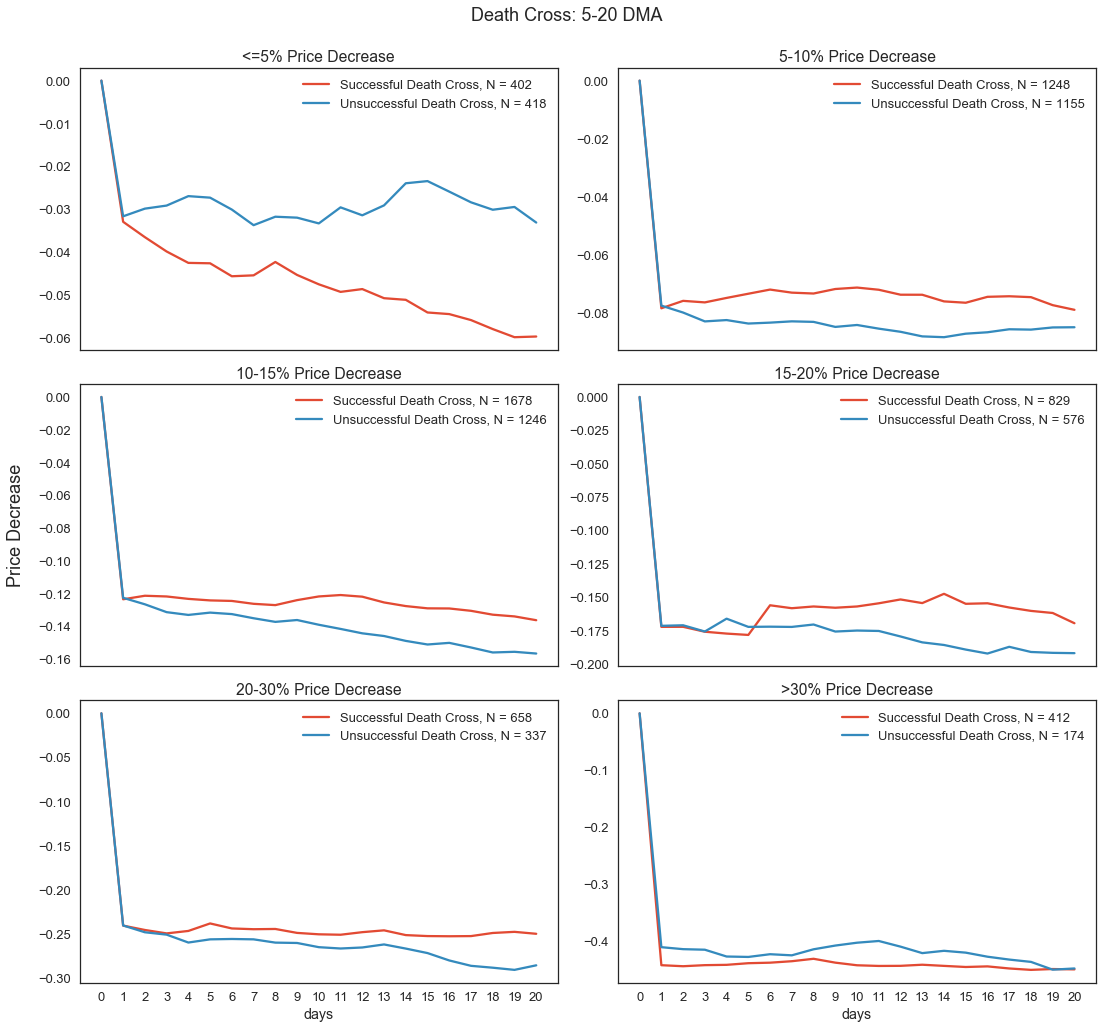

In [301]:
fig, axes = plt.subplots(3, 2, sharex=True)

#Death cross, price <= 5% Decrease
dcs2_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [15, 15])
dcf2_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].legend(['Successful Death Cross, N = %d'%(dcs2_5.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_5.shape[1]-2)])
axes[0,0].set_xticks(range(21))
axes[0,0].set_title('<=5% Price Decrease')

#Death cross, price 5-10% Decrease
dcs2_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
dcf2_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].legend(['Successful Death Cross, N = %d'%(dcs2_5_10.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_5_10.shape[1]-2)])
axes[0,1].set_xticks(range(21));
axes[0,1].set_title('5-10% Price Decrease')


#Death cross, price 10-15% Decrease
dcs2_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
dcf2_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].legend(['Successful Death Cross, N = %d'%(dcs2_10_15.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_10_15.shape[1]-2)])
axes[1,0].set_xticks(range(21));
axes[1,0].set_title('10-15% Price Decrease')


#Death cross, price 15-20% Decrease
dcs2_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
dcf2_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].legend(['Successful Death Cross, N = %d'%(dcs2_15_20.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_15_20.shape[1]-2)])
axes[1,1].set_xticks(range(21));
axes[1,1].set_title('15-20% Price Decrease')


#Death cross, price 20-30% Decrease
dcs2_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
dcf2_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].legend(['Successful Death Cross, N = %d'%(dcs2_20_30.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_20_30.shape[1]-2)])
axes[2,0].set_xticks(range(21));
axes[2,0].set_title('20-30% Price Decrease')


#Death cross, price > 30% Decrease
dcs2_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
dcf2_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].legend(['Successful Death Cross, N = %d'%(dcs2_30.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_30.shape[1]-2)])
axes[2,1].set_xticks(range(21));
axes[2,1].set_title('>30% Price Decrease');

fig.suptitle('Death Cross: 5-20 DMA', size = 18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(-0.01, 0.5, 'Price Decrease', ha='center', va='center', rotation='vertical', size = 18);


In [131]:
#look at increases/decreases in volume along with price increases

#volume < 50DMA
%time vcu_b = get_price_deviations(up[up.cur_day_volume < up.volume_50_dma], prices[prices.ticker.isin(up[up.cur_day_volume < up.volume_50_dma].ticker)])
#volume >= 50DMA
%time vcu_a = get_price_deviations(up[up.cur_day_volume >= up.volume_50_dma], prices[prices.ticker.isin(up[up.cur_day_volume >= up.volume_50_dma].ticker)])

CPU times: user 15.4 s, sys: 46.7 ms, total: 15.5 s
Wall time: 15.5 s
# of stocks with volume < 50DMA and price went up: 510
CPU times: user 30min 53s, sys: 8.79 s, total: 31min 2s
Wall time: 31min 16s
# of stocks with volume > 50DMA and price went up: 9167


In [132]:
vcu_b['pct_change_mean'] = vcu_b[[col for col in vcu_b.columns if col != 'days']].mean(1)
vcu_a['pct_change_mean'] = vcu_a[[col for col in vcu_a.columns if col != 'days']].mean(1)

In [134]:
#volume < 50DMA
%time vcd_b = get_price_deviations(down[down.cur_day_volume < down.volume_50_dma], prices[prices.ticker.isin(down[down.cur_day_volume < down.volume_50_dma].ticker)])
#volume >= 50DMA
%time vcd_a = get_price_deviations(down[down.cur_day_volume >= down.volume_50_dma], prices[prices.ticker.isin(down[down.cur_day_volume >= down.volume_50_dma].ticker)])

CPU times: user 24.5 s, sys: 354 ms, total: 24.8 s
Wall time: 26.4 s
# of stocks with volume < 50DMA and price went down: 722
CPU times: user 28min 24s, sys: 11.6 s, total: 28min 36s
Wall time: 29min 29s
# of stocks with volume >= 50DMA and price went down: 8280


In [135]:
vcd_b['pct_change_mean'] = vcd_b[[col for col in vcd_b.columns if col != 'days']].mean(1)
vcd_a['pct_change_mean'] = vcd_a[[col for col in vcd_a.columns if col != 'days']].mean(1)

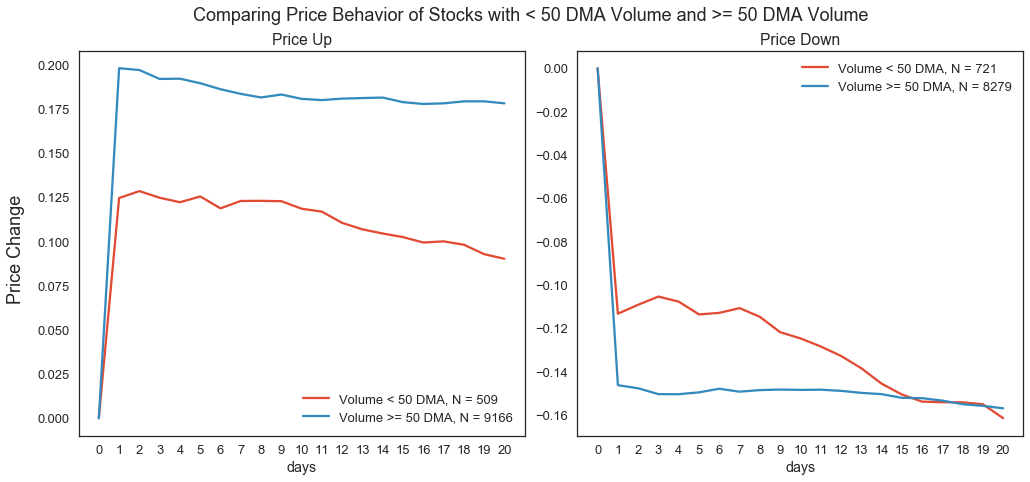

In [304]:
fig, axes = plt.subplots(1, 2)

vcu_b[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0], figsize = [14, 7])
vcu_a[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0])

vcd_b[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1])
vcd_a[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1])

axes[0].legend(['Volume < 50 DMA, N = %d'%(vcu_b.shape[1]-2), 'Volume >= 50 DMA, N = %d'%(vcu_a.shape[1]-2)])
axes[1].legend(['Volume < 50 DMA, N = %d'%(vcd_b.shape[1]-2), 'Volume >= 50 DMA, N = %d'%(vcd_a.shape[1]-2)])

axes[0].set_title('Price Up')
axes[1].set_title('Price Down')

axes[0].set_xticks(range(21));
axes[1].set_xticks(range(21));


fig.suptitle('Comparing Price Behavior of Stocks with < 50 DMA Volume and >= 50 DMA Volume', size = 18)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.text(-0.01, 0.5, 'Price Change', ha='center', va='center', rotation='vertical', size = 18);


In [317]:
#description regex
exec_changes = '''(\Wappoint|\Wname|resign|promote|step down|stepped down|stepping down|retire|replace|depart|\Wnew\W|outgoing|incoming|leaving|left|leave|assume|transition|succeed).*(\Wceo\W|\Wcfo\W|\Wcoo\W|\Wcto\W|director|executive|president|chief|chair|manager)|(\Wceo\W|\Wcfo\W|\Wcoo\W|\Wcto\W|director|executive|president|chief|chair|manager).*(\Wappoint|\Wname|resign|promote|step down|stepped down|retire|replace|depart|\Wnew\W|outgoing|incoming|leaving|left|leave|assume|transition|stepping down|succeed)'''
pharma_approvals = '''fda|food and drug|trial|phase|clinical|placebo|study|Orphan Drug|new drug (submission|application)|pdufa|European Medicines Agency|\WEMA\W|patient|in (vivo|vitro)|(new|updated|reported) data|endpoint|top line (results|data)|efficacy|(pharma|bio|neuro|medic|drug|treatment|therap|oncolog|immun|disease|pdufa|progress|safe|regulat|\Wstage|positive|negative|efficacy|significant|success|cancer|new data).*(patent|drug|cancer|disease)|(patent|drug|cancer|disease).*(pharma|bio|neuro|medic|drug|treatment|therap|oncolog|immun|disease|pdufa|progress|safe|regulat|\Wstage|positive|negative|efficacy|significant|success|cancer|new data)'''
crypto = '''blockchain|cryptocurrency|bitcoin|crypto\W'''
legal = '''lawsuit|ruling|ruled|legal|judge|\Wcourt|\Wjury|arbitration|infringe|litigation|settlement|class action|wrongdoing|settle|verdict'''
earnings = 'earnings|Q4|Q3|Q2|Q1|guidance|\Weps\W|(first|second|third|fourth) quarter|(first|second|third|fourth)-quarter|forecast|upbeat|downbeat|than-expected|(\Wpost|report).*(quarterly|fiscal year|profit|income|revenue|loss|cash flow)|\WFY[^a-zA-Z]|quarterly (profit|result)|(financial|operating) results'
analyst_ratings = '(buy|sell|hold|neutral|overweight|underweight|Equal-weight|Outperform|underperform) rating|initiat(ed|ing) coverage|(buy|sell|hold|neutral|overweight|underweight|Equal-weight|Outperform|underperform) to (buy|sell|hold|neutral|overweight|underweight|Equal-weight|Outperform|underperform)|(up|down)grade|price target|conviction buy'
merge_acq = 'merge|acquisition|acquir|purchased by|\\Wmerging|(buy|sell|purchase) the company|sell itself|to (sell|buy).*deal|go-private|go private|takeover|\Wpurchase of [a-zA-Z]|\Wsale of [a-zA-Z]|agreed to (sell|buy)|buyout|selling itself|(possible|potential) (sale|deal)|offer from|unsolicited|going private|will (buy|sell) [^(back)0-9]'
buyback_dividend = 'repurchase|buyback|buy back|dividend|cash distribution'
deals = 'agreement|deal with|licensed|licensing|license (deal|to|from)|contract|memorandum of|letter of|purchase order|collaborat|strategic deal|partnership|partner with|cooperation'
stake = '\Wstake\W|13(F|G)|investment in the company|(minority|majority|strategic) investment'
offering = 'offering|(pricing|priced).*(stock|notes|financing)|(plans|plan) to offer.*common stock'

In [318]:
#exec change up
%time exec_u = get_price_deviations(up[up.descriptions.str.contains(exec_changes, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(exec_changes, case = False, na=False)].ticker)])
%time exec_d = get_price_deviations(down[down.descriptions.str.contains(exec_changes, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(exec_changes, case = False, na=False)].ticker)])

CPU times: user 3.66 s, sys: 37.2 ms, total: 3.7 s
Wall time: 3.78 s
CPU times: user 3.78 s, sys: 25.8 ms, total: 3.81 s
Wall time: 3.87 s


In [319]:
exec_u['pct_change_mean'] = exec_u[[col for col in exec_u.columns if col != 'days']].mean(1)
exec_d['pct_change_mean'] = exec_d[[col for col in exec_d.columns if col != 'days']].mean(1)

In [320]:
#pharma drug/patent approvals
%time pharma_u = get_price_deviations(up[up.descriptions.str.contains(pharma_approvals, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(pharma_approvals, case = False, na=False)].ticker)])
%time pharma_d = get_price_deviations(down[down.descriptions.str.contains(pharma_approvals, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(pharma_approvals, case = False, na=False)].ticker)])

CPU times: user 27.4 s, sys: 251 ms, total: 27.7 s
Wall time: 28.6 s
CPU times: user 20.3 s, sys: 294 ms, total: 20.6 s
Wall time: 22.3 s


In [321]:
pharma_u['pct_change_mean'] = pharma_u[[col for col in pharma_u.columns if col != 'days']].mean(1)
pharma_d['pct_change_mean'] = pharma_d[[col for col in pharma_d.columns if col != 'days']].mean(1)

In [322]:
#crypto
%time crypto_u = get_price_deviations(up[up.descriptions.str.contains(crypto, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(crypto, case = False, na=False)].ticker)])
%time crypto_d = get_price_deviations(down[down.descriptions.str.contains(crypto, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(crypto, case = False, na=False)].ticker)])

CPU times: user 915 ms, sys: 11.6 ms, total: 927 ms
Wall time: 946 ms
CPU times: user 772 ms, sys: 14.2 ms, total: 787 ms
Wall time: 880 ms


In [323]:
crypto_u['pct_change_mean'] = crypto_u[[col for col in crypto_u.columns if col != 'days']].mean(1)
crypto_d['pct_change_mean'] = crypto_d[[col for col in crypto_d.columns if col != 'days']].mean(1)

In [324]:
#legal
%time legal_u = get_price_deviations(up[up.descriptions.str.contains(legal, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(legal, case = False, na=False)].ticker)])
%time legal_d = get_price_deviations(down[down.descriptions.str.contains(legal, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(legal, case = False, na=False)].ticker)])

CPU times: user 2.39 s, sys: 41 ms, total: 2.43 s
Wall time: 2.74 s
CPU times: user 1.94 s, sys: 31.9 ms, total: 1.97 s
Wall time: 2.19 s


In [325]:
legal_u['pct_change_mean'] = legal_u[[col for col in legal_u.columns if col != 'days']].mean(1)
legal_d['pct_change_mean'] = legal_d[[col for col in legal_d.columns if col != 'days']].mean(1)

In [326]:
#amazon
%time amzn_u = get_price_deviations(up[(up.descriptions.str.contains('amazon', case = False, na=False)) & (up.ticker != 'AMZN')], prices[prices.ticker.isin(up[(up.descriptions.str.contains('amazon', case = False, na=False)) & (up.ticker != 'AMZN')].ticker)])
%time amzn_d = get_price_deviations(down[(down.descriptions.str.contains('amazon', case = False, na=False)) & (down.ticker != 'AMZN')], prices[prices.ticker.isin(down[(down.descriptions.str.contains('amazon', case = False, na=False)) & (down.ticker != 'AMZN')].ticker)])

CPU times: user 409 ms, sys: 7.08 ms, total: 416 ms
Wall time: 442 ms
CPU times: user 324 ms, sys: 3.44 ms, total: 328 ms
Wall time: 333 ms


In [327]:
amzn_u['pct_change_mean'] = amzn_u[[col for col in amzn_u.columns if col != 'days']].mean(1)
amzn_d['pct_change_mean'] = amzn_d[[col for col in amzn_d.columns if col != 'days']].mean(1)

In [328]:
#earnings
%time earnings_u = get_price_deviations(up[up.descriptions.str.contains(earnings, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(earnings, case = False, na=False)].ticker)])
%time earnings_d = get_price_deviations(down[down.descriptions.str.contains(earnings, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(earnings, case = False, na=False)].ticker)])

CPU times: user 4min 20s, sys: 1.1 s, total: 4min 21s
Wall time: 4min 24s
CPU times: user 5min 22s, sys: 2.24 s, total: 5min 24s
Wall time: 5min 33s


In [329]:
earnings_u['pct_change_mean'] = earnings_u[[col for col in earnings_u.columns if col != 'days']].mean(1)
earnings_d['pct_change_mean'] = earnings_d[[col for col in earnings_d.columns if col != 'days']].mean(1)

In [330]:
#analyst
%time analyst_u = get_price_deviations(up[up.descriptions.str.contains(analyst_ratings, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(analyst_ratings, case = False, na=False)].ticker)])
%time analyst_d = get_price_deviations(down[down.descriptions.str.contains(analyst_ratings, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(analyst_ratings, case = False, na=False)].ticker)])

CPU times: user 58.5 s, sys: 383 ms, total: 58.9 s
Wall time: 59.9 s
CPU times: user 54.6 s, sys: 694 ms, total: 55.3 s
Wall time: 57.2 s


In [331]:
analyst_u['pct_change_mean'] = analyst_u[[col for col in analyst_u.columns if col != 'days']].mean(1)
analyst_d['pct_change_mean'] = analyst_d[[col for col in analyst_d.columns if col != 'days']].mean(1)

In [332]:
#mergers and acquisitions
%time merge_u = get_price_deviations(up[up.descriptions.str.contains(merge_acq, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(merge_acq, case = False, na=False)].ticker)])
%time merge_d = get_price_deviations(down[down.descriptions.str.contains(merge_acq, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(merge_acq, case = False, na=False)].ticker)])

CPU times: user 25.2 s, sys: 152 ms, total: 25.4 s
Wall time: 25.6 s
CPU times: user 5.47 s, sys: 32.2 ms, total: 5.5 s
Wall time: 5.55 s


In [333]:
merge_u['pct_change_mean'] = merge_u[[col for col in merge_u.columns if col != 'days']].mean(1)
merge_d['pct_change_mean'] = merge_d[[col for col in merge_d.columns if col != 'days']].mean(1)

In [334]:
#buy back and dividend announcements outside of earnings announcement
%time bd_u = get_price_deviations(up[up.descriptions.str.contains(buyback_dividend, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(buyback_dividend, case = False, na=False)].ticker)])
%time bd_d = get_price_deviations(down[down.descriptions.str.contains(buyback_dividend, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(buyback_dividend, case = False, na=False)].ticker)])

CPU times: user 1.77 s, sys: 9.86 ms, total: 1.78 s
Wall time: 1.8 s
CPU times: user 1.2 s, sys: 9.38 ms, total: 1.21 s
Wall time: 1.22 s


In [335]:
bd_u['pct_change_mean'] = bd_u[[col for col in bd_u.columns if col != 'days']].mean(1)
bd_d['pct_change_mean'] = bd_d[[col for col in bd_d.columns if col != 'days']].mean(1)

In [336]:
#deals/agreements/partnerships/etc.
%time d_u = get_price_deviations(up[up.descriptions.str.contains(deals, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(deals, case = False, na=False)].ticker)])
%time d_d = get_price_deviations(down[down.descriptions.str.contains(deals, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(deals, case = False, na=False)].ticker)])

CPU times: user 14.1 s, sys: 100 ms, total: 14.2 s
Wall time: 14.6 s
CPU times: user 2.55 s, sys: 32.1 ms, total: 2.59 s
Wall time: 2.75 s


In [337]:
d_u['pct_change_mean'] = d_u[[col for col in d_u.columns if col != 'days']].mean(1)
d_d['pct_change_mean'] = d_d[[col for col in d_d.columns if col != 'days']].mean(1)

In [338]:
#stake in companies
%time stake_u = get_price_deviations(up[up.descriptions.str.contains(stake, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(stake, case = False, na=False)].ticker)])
%time stake_d = get_price_deviations(down[down.descriptions.str.contains(stake, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(stake, case = False, na=False)].ticker)])

CPU times: user 2.08 s, sys: 25 ms, total: 2.1 s
Wall time: 2.17 s
CPU times: user 730 ms, sys: 11.7 ms, total: 742 ms
Wall time: 769 ms


In [339]:
stake_u['pct_change_mean'] = stake_u[[col for col in stake_u.columns if col != 'days']].mean(1)
stake_d['pct_change_mean'] = stake_d[[col for col in stake_d.columns if col != 'days']].mean(1)

In [340]:
#stock offerings
%time offering_u = get_price_deviations(up[up.descriptions.str.contains(offering, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(offering, case = False, na=False)].ticker)])
%time offering_d = get_price_deviations(down[down.descriptions.str.contains(offering, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(offering, case = False, na=False)].ticker)])

CPU times: user 1.87 s, sys: 25 ms, total: 1.89 s
Wall time: 1.96 s
CPU times: user 41.2 s, sys: 425 ms, total: 41.6 s
Wall time: 43.6 s


In [341]:
offering_u['pct_change_mean'] = offering_u[[col for col in offering_u.columns if col != 'days']].mean(1)
offering_d['pct_change_mean'] = offering_d[[col for col in offering_d.columns if col != 'days']].mean(1)

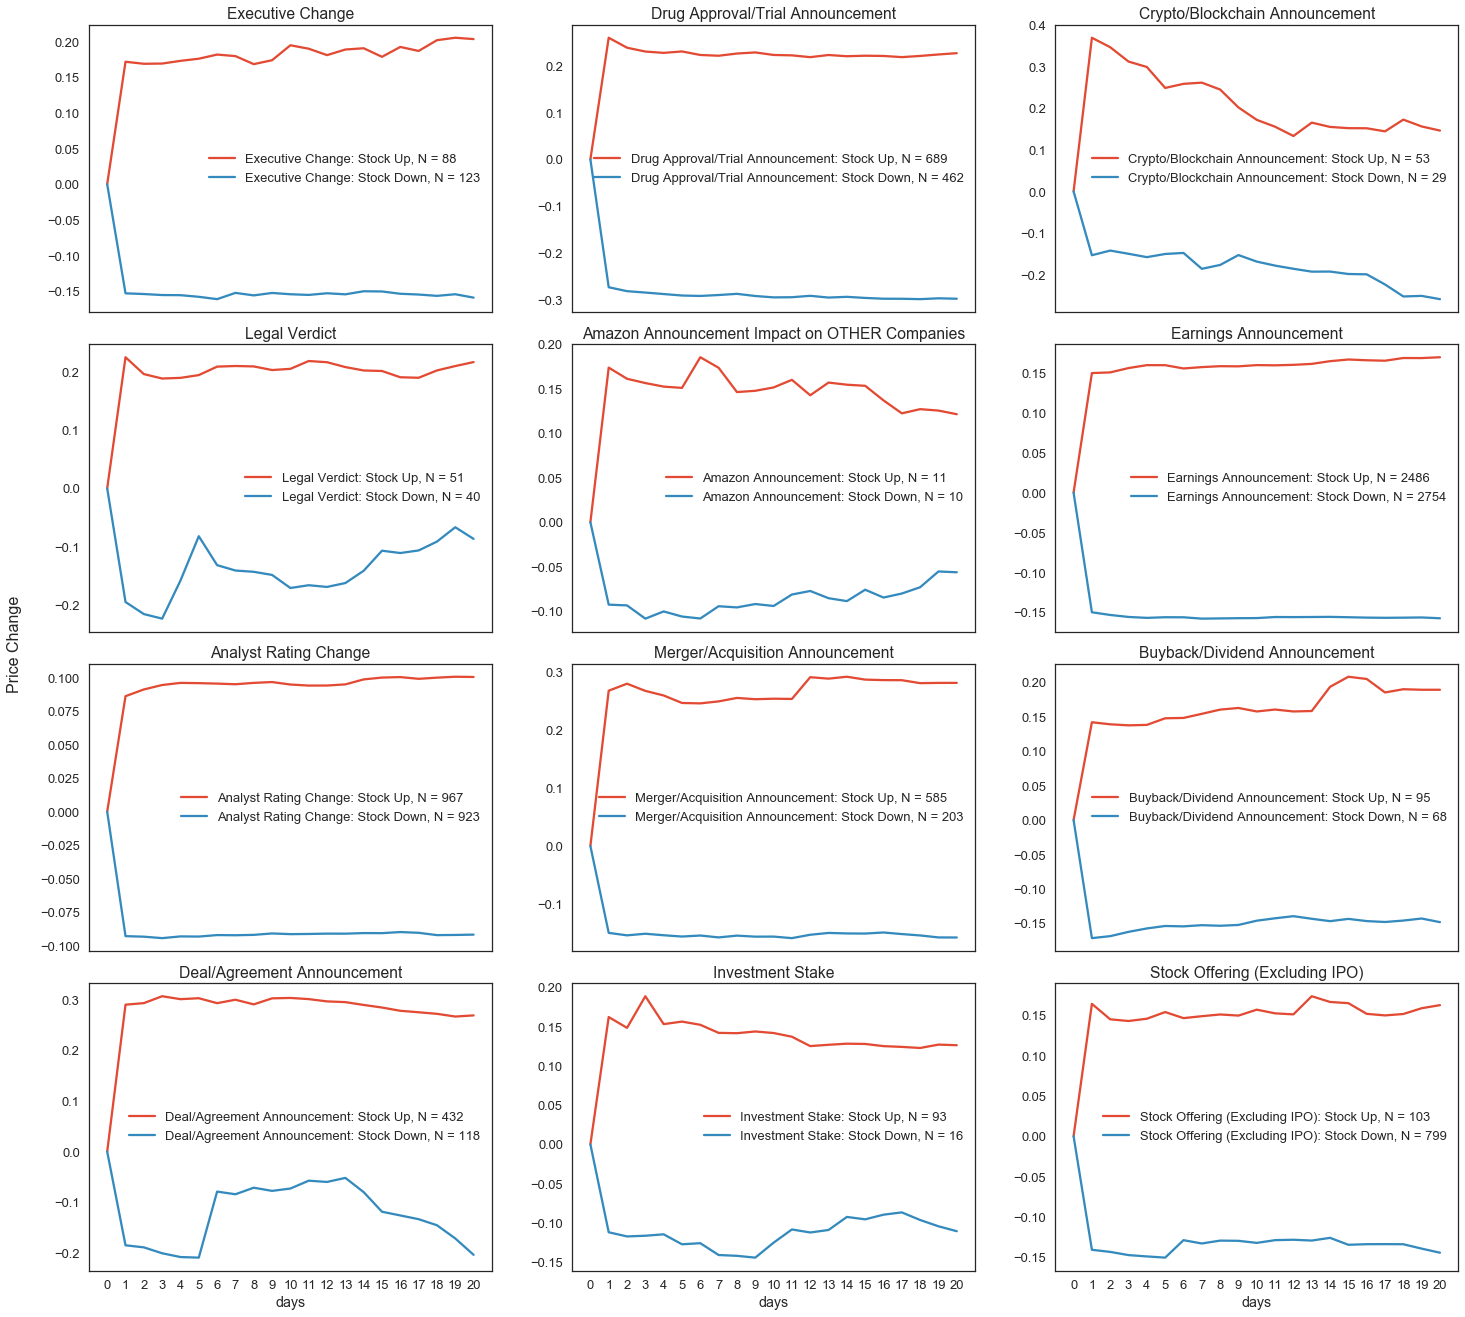

In [342]:
fig, axes = plt.subplots(4,3, sharex=True)

exec_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [20, 20])
exec_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].set_xticks(range(21))
axes[0,0].legend(['Executive Change: Stock Up, N = %d'%(exec_u.shape[1]-2), 'Executive Change: Stock Down, N = %d'%(exec_d.shape[1]-2)])
axes[0,0].set_title('Executive Change')


pharma_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
pharma_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].set_xticks(range(21))
axes[0,1].legend(['Drug Approval/Trial Announcement: Stock Up, N = %d'%(pharma_u.shape[1]-2), 
            'Drug Approval/Trial Announcement: Stock Down, N = %d'%(pharma_d.shape[1]-2)])
axes[0,1].set_title('Drug Approval/Trial Announcement')


crypto_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,2])
crypto_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,2])
axes[0,2].set_xticks(range(21))
axes[0,2].legend(['Crypto/Blockchain Announcement: Stock Up, N = %d'%(crypto_u.shape[1]-2), 'Crypto/Blockchain Announcement: Stock Down, N = %d'%(crypto_d.shape[1]-2)])
axes[0,2].set_title('Crypto/Blockchain Announcement')


legal_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
legal_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].set_xticks(range(21))
axes[1,0].legend(['Legal Verdict: Stock Up, N = %d'%(legal_u.shape[1]-2), 'Legal Verdict: Stock Down, N = %d'%(legal_d.shape[1]-2)])
axes[1,0].set_title('Legal Verdict')


amzn_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
amzn_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].set_xticks(range(21))
axes[1,1].legend(['Amazon Announcement: Stock Up, N = %d'%(amzn_u.shape[1]-2), 'Amazon Announcement: Stock Down, N = %d'%(amzn_d.shape[1]-2)])
axes[1,1].set_title('Amazon Announcement Impact on OTHER Companies')

earnings_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,2])
earnings_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,2])
axes[1,2].set_xticks(range(21))
axes[1,2].legend(['Earnings Announcement: Stock Up, N = %d'%(earnings_u.shape[1]-2), 'Earnings Announcement: Stock Down, N = %d'%(earnings_d.shape[1]-2)])
axes[1,2].set_title('Earnings Announcement')

analyst_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
analyst_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].set_xticks(range(21))
axes[2,0].legend(['Analyst Rating Change: Stock Up, N = %d'%(analyst_u.shape[1]-2), 'Analyst Rating Change: Stock Down, N = %d'%(analyst_d.shape[1]-2)])
axes[2,0].set_title('Analyst Rating Change')

merge_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
merge_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].set_xticks(range(21))
axes[2,1].legend(['Merger/Acquisition Announcement: Stock Up, N = %d'%(merge_u.shape[1]-2), 'Merger/Acquisition Announcement: Stock Down, N = %d'%(merge_d.shape[1]-2)])
axes[2,1].set_title('Merger/Acquisition Announcement')

bd_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,2])
bd_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,2])
axes[2,2].set_xticks(range(21))
axes[2,2].legend(['Buyback/Dividend Announcement: Stock Up, N = %d'%(bd_u.shape[1]-2), 'Buyback/Dividend Announcement: Stock Down, N = %d'%(bd_d.shape[1]-2)])
axes[2,2].set_title('Buyback/Dividend Announcement')

d_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,0])
d_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,0])
axes[3,0].set_xticks(range(21))
axes[3,0].legend(['Deal/Agreement Announcement: Stock Up, N = %d'%(d_u.shape[1]-2), 'Deal/Agreement Announcement: Stock Down, N = %d'%(d_d.shape[1]-2)])
axes[3,0].set_title('Deal/Agreement Announcement')

stake_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,1])
stake_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,1])
axes[3,1].set_xticks(range(21))
axes[3,1].legend(['Investment Stake: Stock Up, N = %d'%(stake_u.shape[1]-2), 'Investment Stake: Stock Down, N = %d'%(stake_d.shape[1]-2)])
axes[3,1].set_title('Investment Stake')

offering_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,2])
offering_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,2])
axes[3,2].set_xticks(range(21))
axes[3,2].legend(['Stock Offering (Excluding IPO): Stock Up, N = %d'%(offering_u.shape[1]-2), 'Stock Offering (Excluding IPO): Stock Down, N = %d'%(offering_d.shape[1]-2)])
axes[3,2].set_title('Stock Offering (Excluding IPO)')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(-0.01, 0.5, 'Price Change', ha='center', va='center', rotation='vertical', size = 16);


In [343]:
df['exec_change'] = 0
df.loc[df.descriptions.str.contains(exec_changes, case = False, na=False), 'exec_change'] = 1

df['pharma_approval'] = 0
df.loc[df.descriptions.str.contains(pharma_approvals, case = False, na=False), 'pharma_approval'] = 1

df['crypto'] = 0
df.loc[df.descriptions.str.contains(crypto, case = False, na=False), 'crypto'] = 1

df['legal'] = 0
df.loc[df.descriptions.str.contains(legal, case = False, na=False), 'legal'] = 1

df['merge_acq'] = 0
df.loc[df.descriptions.str.contains(merge_acq, case = False, na=False), 'merge_acq'] = 1

df['buyback_dividend'] = 0
df.loc[df.descriptions.str.contains(buyback_dividend, case = False, na=False), 'buyback_dividend'] = 1

df['deal'] = 0
df.loc[df.descriptions.str.contains(deals, case = False, na=False), 'deal'] = 1

df['investment_stake'] = 0
df.loc[df.descriptions.str.contains(stake, case = False, na=False), 'investment_stake'] = 1

df['stock_offering'] = 0
df.loc[df.descriptions.str.contains(offering, case = False, na=False), 'stock_offering'] = 1

df['amazon_effect'] = 0
df.loc[(df.descriptions.str.contains('amazon', case = False, na=False)) & 
       (df.ticker != 'AMZN'), 'amazon_effect'] = 1


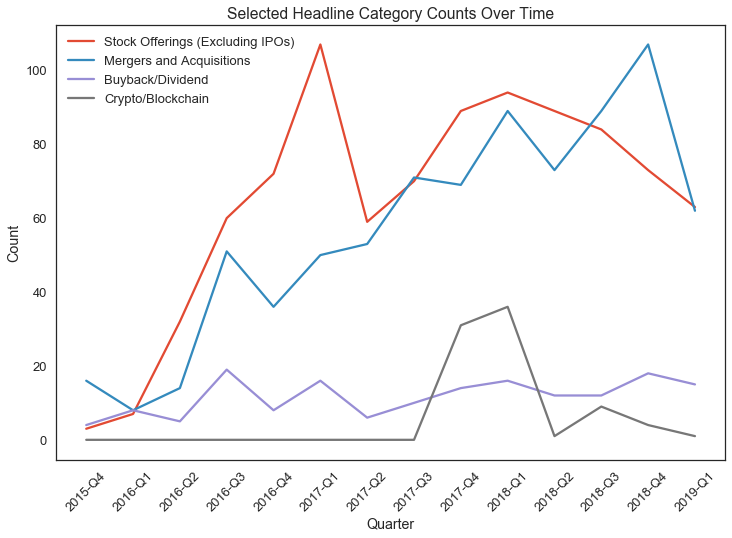

In [344]:
event_cal = df.groupby(pd.Grouper(freq="Q", key = 'date')).sum()[['stock_offering', 'merge_acq', 'buyback_dividend', 'crypto']]
fig = plt.subplot()
event_cal.plot(ax = fig, figsize = [12, 8])

plt.xticks(event_cal.index,['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4',
                   '2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1'], rotation = 45);
plt.legend(['Stock Offerings (Excluding IPOs)', 'Mergers and Acquisitions', 'Buyback/Dividend', 'Crypto/Blockchain'])
plt.title('Selected Headline Category Counts Over Time')
plt.xlabel('Quarter')
plt.ylabel('Count');